# Идея 1: Выбрать ряд без последнего значения; найти тренд во временном ряду; вычесть его из временного ряда; убедиться, что ряд теперь случаен и сказать, что раз так, то все эти значения - реализации нек. с.в.; найти параметры неизвестного распределения (в частности, ско); предсказать следующее значение; предсказанное значние - это как бы тренд, поэтому вычитаем его из последнего значния и смотрим, насколько вероятно, что оно принадлежит распределению (считаем выборочный 95 квантиль и сравниваем со значением)

# Идея 2: Считать скользящее среднее и скользящее ско по предыдущим K значениям. Тогда возможно посчитать ско и среднее и для последнего значения тоже, а затем сравнить значение с реальным

# Идея 3: Prophet. 

## Фишка вот в чем: Prophet умеет строить доверительный интервал. Модель раскладывает ряд на тренд, сезонность и шум (функции от времени). При этом у каждой такой части есть свои параметры. Причем эти параметры не выбираются "лучшим" образом, а считаются взятыми из некоторого распределения. Такой подход называется Байесовским. Теперь всупает в силу метод Монте-Карло. Мы генерим параметры согласно их распределениям. Затем смотрим на такое распределение, к примеру, для t-ого времени и считаем доверительный интервал.

https://chatgpt.com/share/66ec1c23-756c-8009-bebc-6f8e7e57a9d7

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import kstest
from statistics import mean, stdev
from math import floor
from prophet import Prophet

In [11]:
def quantile(arr, p):
    arr.sort()
    return arr[floor(len(arr) * p)]

### Читаю данные

count    730.000000
mean      46.460959
std        4.314479
min       33.000000
25%       43.625000
50%       47.000000
75%       50.000000
max       57.000000
Name: AvgTemp, dtype: float64


<AxesSubplot: xlabel='DATE'>

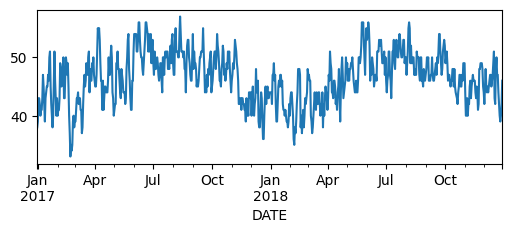

In [248]:
df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)['AvgTemp'].iloc[-730:]
df=df.interpolate()
print(df.describe())
df.plot(figsize=(6,2))

# Идея 1

### Выделяю тренд

In [13]:
def moving_avg(sample, window: int):
    """
    :param sample: moving_avg method will extract trend from sample
    :param window: window width
    :return: trend by moving_avg
    """
    gap = int((window - 1) / 2)
    output = [sample[0]]
    for i in range(1, gap):
        output.append(mean(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        output.append(mean(sample[i-gap:i+gap]))
    for i in range(len(sample) - gap, len(sample)):
        output.append(mean(sample[2*i - 2*len(sample):]))  # negative index

    return output

def exp_avg(sample, alfa):
    """
    :param sample: exp_avg method will extract trend from sample
    :param alfa: in [0, 1]; if -> 0, than model takes in account previous values more. Conversely - conversely
    :return: trend by exp_avg
    """
    output = [sample[0]]
    for i in range(1, len(sample)):
        output.append(alfa * sample[i] + (1 - alfa) * output[i-1])

    return output

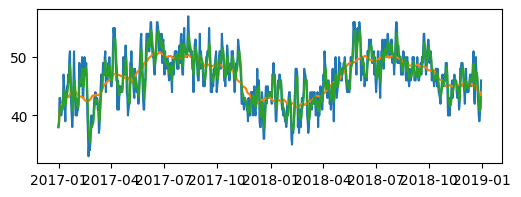

In [34]:
MA = moving_avg(list(df), 50)
EA = exp_avg(list(df), 0.4)

plt.figure(figsize=(6,2))
plt.plot(df.index, df)
plt.plot(df.index, MA)
plt.plot(df.index, EA)

### Вычитаю тернд

<AxesSubplot: xlabel='DATE'>

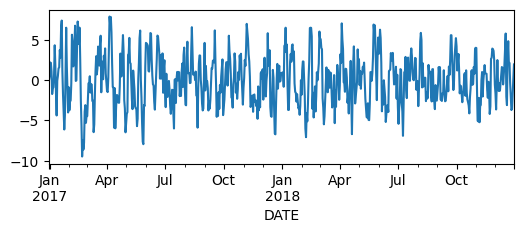

In [35]:
MA_errors = df - MA
MA_errors.plot(figsize=(6,2))

<AxesSubplot: xlabel='DATE'>

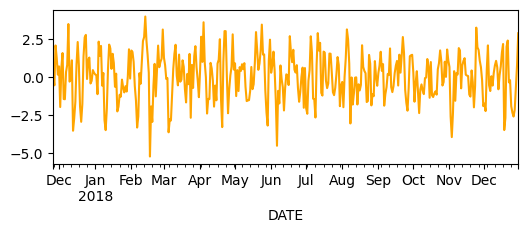

In [36]:
EA_errors = df - EA
EA_errors.iloc[-400:].plot(figsize=(6,2), color='orange')

### Пробую найти тренд через линейную регрессию

In [17]:
from sklearn.linear_model import LinearRegression

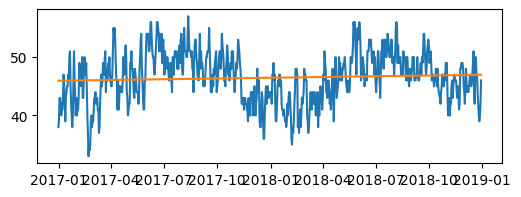

In [18]:
time = np.arange(len(df.index))
model = LinearRegression()
time = time.reshape(-1, 1)  # Преобразование для модели
model.fit(time, df)
LR = model.predict(time)

plt.figure(figsize=(6,2))
plt.plot(df.index, df)
plt.plot(df.index, LR)

### Очевидно, ничего не получилось

### Попробуем другой метод

DATE
2016-12-31   -1.911110
2017-01-01   -0.882188
2017-01-02    2.582912
2017-01-03    1.987777
2017-01-04    0.789967
Name: resid, dtype: float64

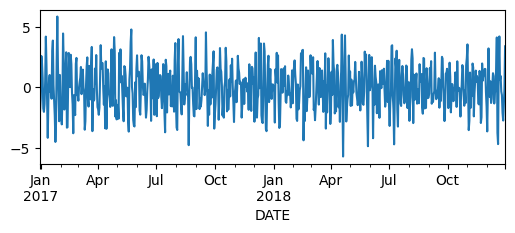

In [19]:
stl = STL(df, seasonal=365)
STD = stl.fit()

# df.plot()
# STD.trend.plot()
# STD.seasonal.plot()
resid = STD.resid
resid.plot(figsize=(6,2))
resid.head()

In [20]:
print('STD pvalue: ', kstest(resid, 'norm').pvalue)
print('STD pvalue: ', kstest(EA_errors, 'norm').pvalue)

STD pvalue:  5.220409936616638e-17
STD pvalue:  0.00036630091058477426


### Быстро найти расперделение не удалось. Тогда можно просто проверить ряд на случанойсть. Если случаен, тогда брать распределение из всех значений кроме последнего, находить его стандартное отклонение и смотреть на последнее значение в ряду

In [21]:
def turn_point(lst):
    dx = np.diff(lst, axis=0)
    return np.sum(dx[1:] * dx[:-1] < 0)

th_val = (2/3) * (len(df) - 2)

In [37]:
print('resid STD', turn_point(resid))
print('resid MA', turn_point(MA_errors))
print('resid EA', turn_point(EA_errors))
print('theoretical', th_val)

resid STD 400
resid MA 347
resid EA 386
theoretical 485.3333333333333


### Ряды мало похожи на случаные

<AxesSubplot: >

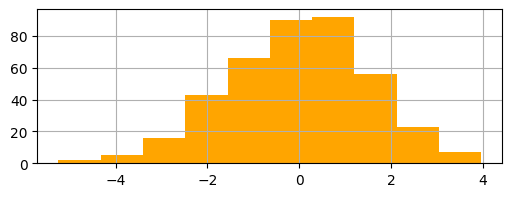

In [38]:
EA_errors.iloc[-400:].hist(figsize=(6,2), color='orange')

# Идея 2

In [220]:
def get_avg(data, window):
    return sum([data.shift(i) for i in range(1, 1+window)]) / window

def get_std(data, data_mean, window):
    return (sum([(data.shift(i) - data_mean)**2 for i in range(1, 1+window)]) / (window-1)) ** 0.5


In [232]:
window=10

df_new = pd.DataFrame(df).iloc[:-1]
df_new['MA'] = get_avg(df_new['AvgTemp'], window)
df_new['STD'] = get_std(df_new['AvgTemp'], df_new['MA'], window)
df_new['MA+'] = df_new['MA'] + df_new['STD']
df_new['MA-'] = df_new['MA'] - df_new['STD']
df_new.tail(5)

,AvgTemp,MA,STD,MA+,MA-
DATE,,,,,
2018-12-25,42.0,46.8,2.973961,49.773961,43.826039
2018-12-26,40.0,46.3,3.335000,49.635000,42.965000
2018-12-27,39.0,45.4,3.717825,49.117825,41.682175
2018-12-28,40.0,44.2,3.645393,47.845393,40.554607
2018-12-29,42.0,43.9,3.871549,47.771549,40.028451


In [233]:
predicted_MA = get_avg(df.iloc[-window - 1:], window).loc['2018-12-30']
predicted_STD = get_std(df.iloc[-window - 1:], predicted_MA, window).loc['2018-12-30']

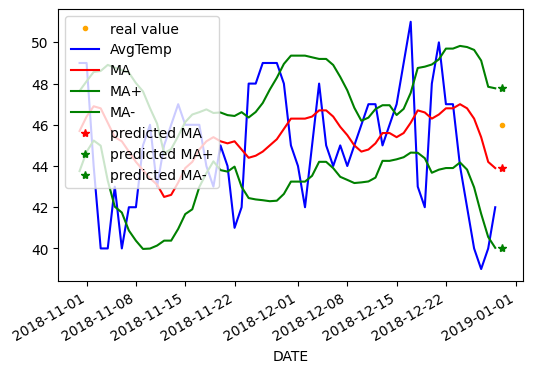

In [238]:
gap = 60
s = (6,4)

plt.plot(df.index[-1:], df[-1:], '.', color='orange', label='real value')

df_new['AvgTemp'].iloc[-gap:].plot(figsize=s, color='blue')
df_new['MA'].iloc[-gap:].plot(figsize=s, color='red')
df_new['MA+'].iloc[-gap:].plot(figsize=s, color='green')
df_new['MA-'].iloc[-gap:].plot(figsize=s, color='green')

plt.plot(pd.Timestamp('2018-12-30'), predicted_MA, '*', label='predicted MA', color='red')
plt.plot(pd.Timestamp('2018-12-30'), predicted_MA + predicted_STD, '*', label='predicted MA+', color='green')
plt.plot(pd.Timestamp('2018-12-30'), predicted_MA - predicted_STD, '*', label='predicted MA-', color='green')

plt.legend()

# Идея 3

In [296]:
df_prophet = df.iloc[:-1].reset_index()
test_value = df.iloc[-1:].reset_index().rename(columns={'DATE': 'ds', 'AvgTemp': 'y'})
df_prophet = df_prophet.rename(columns={'DATE': 'ds', 'AvgTemp': 'y'})
print(df_prophet.tail(3), '\n')
print(test_value)

            ds     y
726 2018-12-27  39.0
727 2018-12-28  40.0
728 2018-12-29  42.0 

          ds     y
0 2018-12-30  46.0


In [307]:
CI = 0.95
m = Prophet(interval_width=CI)
m.fit(df_prophet)

16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing


In [323]:
future = m.make_future_dataframe(periods=1)
future.tail(3)

,ds
727,2018-12-28
728,2018-12-29
729,2018-12-30


In [329]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
727,2018-12-28,44.712163,38.483868,50.740803
728,2018-12-29,44.505884,38.350811,51.146450
729,2018-12-30,44.492750,37.604958,51.114422


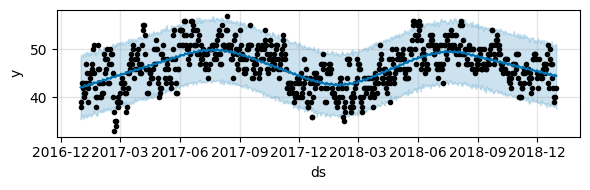

In [330]:
fig1 = m.plot(forecast, figsize=(6,2))

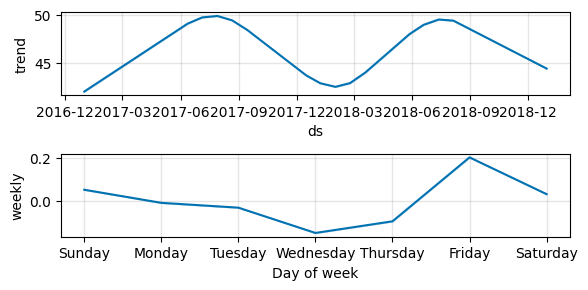

In [331]:
### это Prophet, разложенный по компонентам. 
### Если прогноз делать на более долгий срок, то тренд будет представляться в виде разъезжающегоя доверительного интервала

fig2 = m.plot_components(forecast, figsize=(6,3))

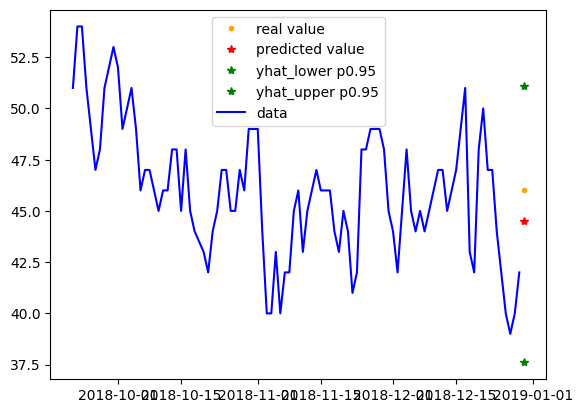

In [332]:
gap = 100

plt.plot(test_value['ds'], test_value['y'], '.', color='orange', label='real value')
plt.plot(forecast['ds'].iloc[-1], forecast['yhat'].iloc[-1], '*', color='red', label='predicted value')
plt.plot(forecast['ds'].iloc[-1], forecast['yhat_lower'].iloc[-1], '*', color='green', label=f'yhat_lower p{CI}')
plt.plot(forecast['ds'].iloc[-1], forecast['yhat_upper'].iloc[-1], '*', color='green', label=f'yhat_upper p{CI}')
plt.plot(df_prophet['ds'].iloc[-gap:], df_prophet['y'].iloc[-gap:], color='blue', label='data')
plt.legend()

### Видим, что по Prophet-у с вероятностью 0.95 мы не можем отвергнуть гипотезу о том, что значение не аномально. Значит, значение не аномально

# Итог: 

## Выделить тренд и вычесть его из временного ряда (по Идее 1) удалось, но остаток не оказался случаныйм. Поэтому первая идея не сработала

## Вторая идея вроде бы и ничего, но только больно неуниверсальна. Плюс видно, что из-за того, что новое значение предсказывается из пердыдущих, есть как бы "запаздываение предсказания"

## Prophet выглядит очень надежно и уверенно. Плюс, он довольно мобильный (можно явно указывать доверительные интервалы). Отдаю ему предпочтение в этой задаче и считаю решением.